In [1]:
%%HTML
<style> code {background-color : pink !important;} </style>

Advanced Lane Lines
===

### Run the code in the cell below to extract object points and image points for camera calibration.  

In [4]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
chess_grid_width = 9
chess_grid_height = 6
objp = np.zeros((chess_grid_width*chess_grid_height,3), np.float32)

objp[:,:2] = np.mgrid[0:chess_grid_width, 0:chess_grid_height].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (chess_grid_width,chess_grid_height), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (chess_grid_width,chess_grid_height), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

### If the above cell ran sucessfully, you should now have `objpoints` and `imgpoints` needed for camera calibration.  Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

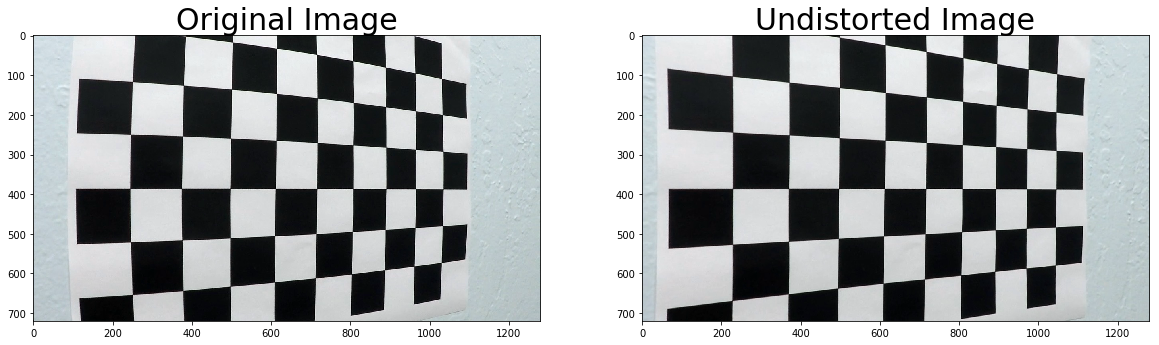

In [7]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration5.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_wide/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [25]:
## generate binary image

In [32]:
def pipeline(img, s_thresh=(100, 255), sx_thresh=(100, 255)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    s_channel = np.uint8(255*s_channel/np.max(s_channel))
#     print('s_channel')
#     print(s_channel)
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
#     return s_binary
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
#     print('color_binary')
#     print(color_binary)
    return color_binary

In [28]:
def undistort(img, mtx, dist):
    img_size = (img.shape[1], img.shape[0])
    # ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst
    
def unwarp(img, src_corners, dst_corners):
    print('asdf')
#     # Pass in your image into this function
#     # Write code to do the following steps
#     # 1) Undistort using mtx and dist
    
# #     f, ax1 = plt.subplots(1, 1, figsize=(20,10))
# #     ax1.set_title('Undistorted Image', fontsize=30)
# #     ax1.imshow(dst)
#     # 2) Convert to grayscale
#     gray = cv2.cvtColor(dst,cv2.COLOR_BGR2GRAY)
# #     f, ax1 = plt.subplots(1, 1, figsize=(20,10))
# #     ax1.set_title('gray Image', fontsize=30)
# #     ax1.imshow(gray)

        # b) define 4 source points src = np.float32([[,],[,],[,],[,]])

             #Note: you could pick any four of the detected corners 
             # as long as those four corners define a rectangle
             #One especially smart way to do this would be to use four well-chosen
             # corners that were automatically detected during the undistortion steps
             #We recommend using the automatic detection of corners in your code

        # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
        # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    #delete the next two lines
    # M = None
    # warped = np.copy(img) 
    return warped, M




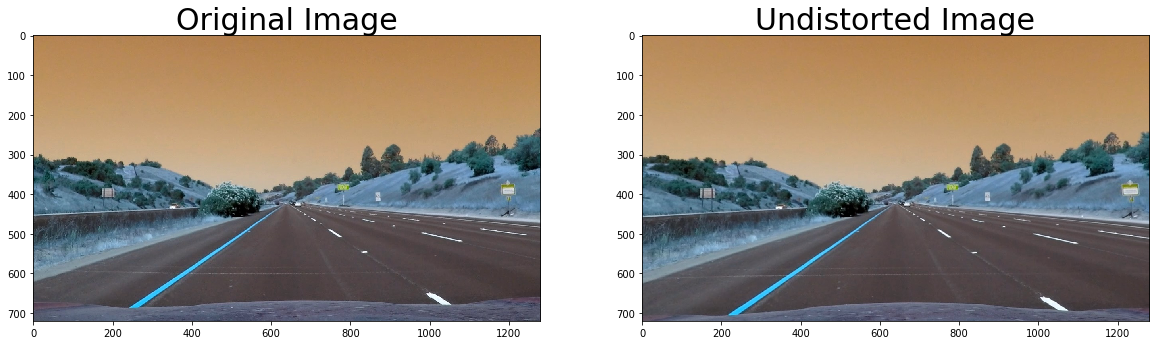

In [29]:
img = cv2.imread('test_images/straight_lines1.jpg')
nx = chess_grid_width # the number of inside corners in x
ny = chess_grid_height # the number of inside corners in y
# print('img')
# print(img)

# print('mtx')
# print(mtx)
# print('dist')
# print(dist)

img2 = undistort(img, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img2)
ax2.set_title('Undistorted Image', fontsize=30)


img = img2

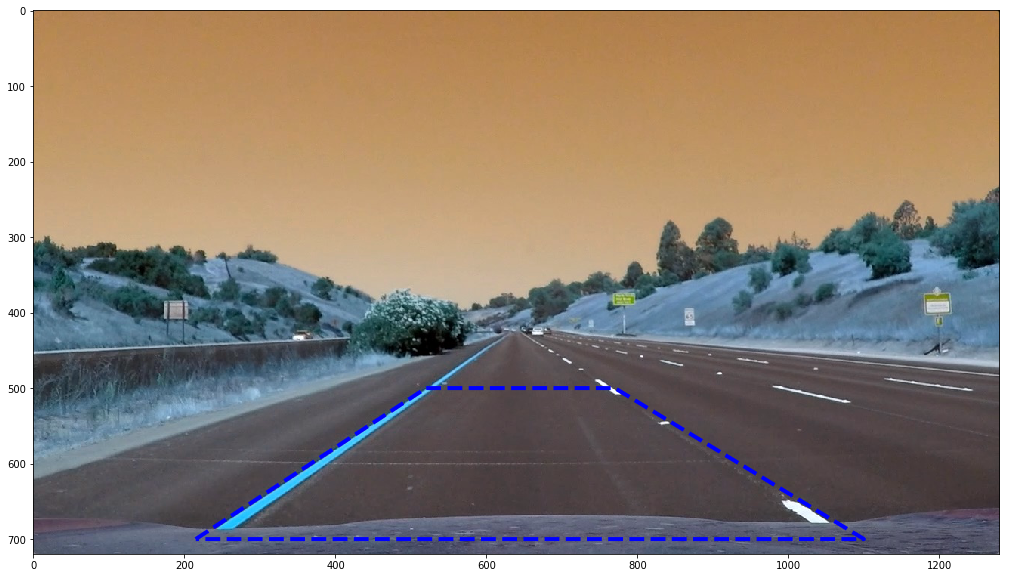

In [60]:
left_bottom = [215,700]
left_top = [520,500]
right_top = [770,500]
right_bottom = [1100,700]
src = np.float32([left_top,right_top,left_bottom,right_bottom])

x = [left_bottom[0], left_top[0], right_top[0], right_bottom[0], left_bottom[0]]
y = [left_bottom[1], left_top[1], right_top[1], right_bottom[1], left_bottom[1]]
plt.figure(figsize=(20,10))
plt.plot(x, y, 'b--', lw=4)
plt.imshow(img)
plt.show()
    # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
dst = np.float32([[100,500],[1200,500],[100,700],[1200,700]])

asdf


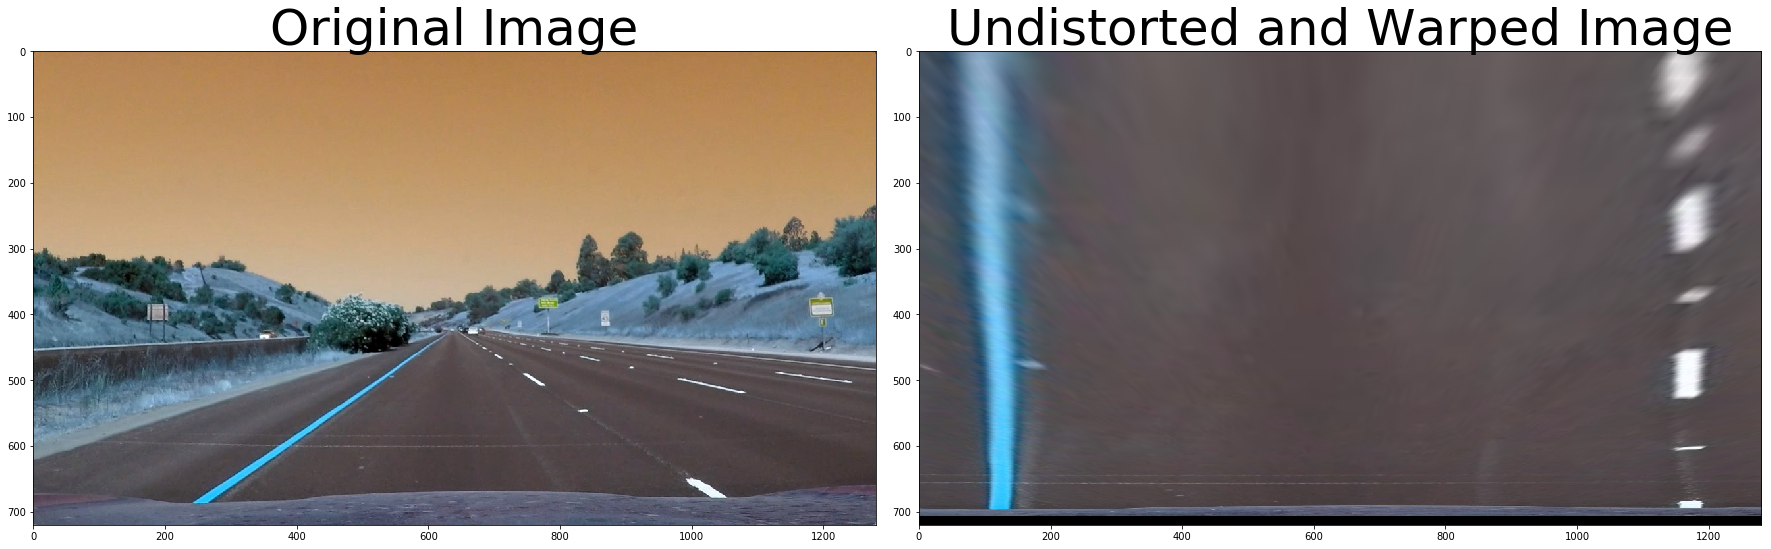

In [62]:
top_down, perspective_M = unwarp(img, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

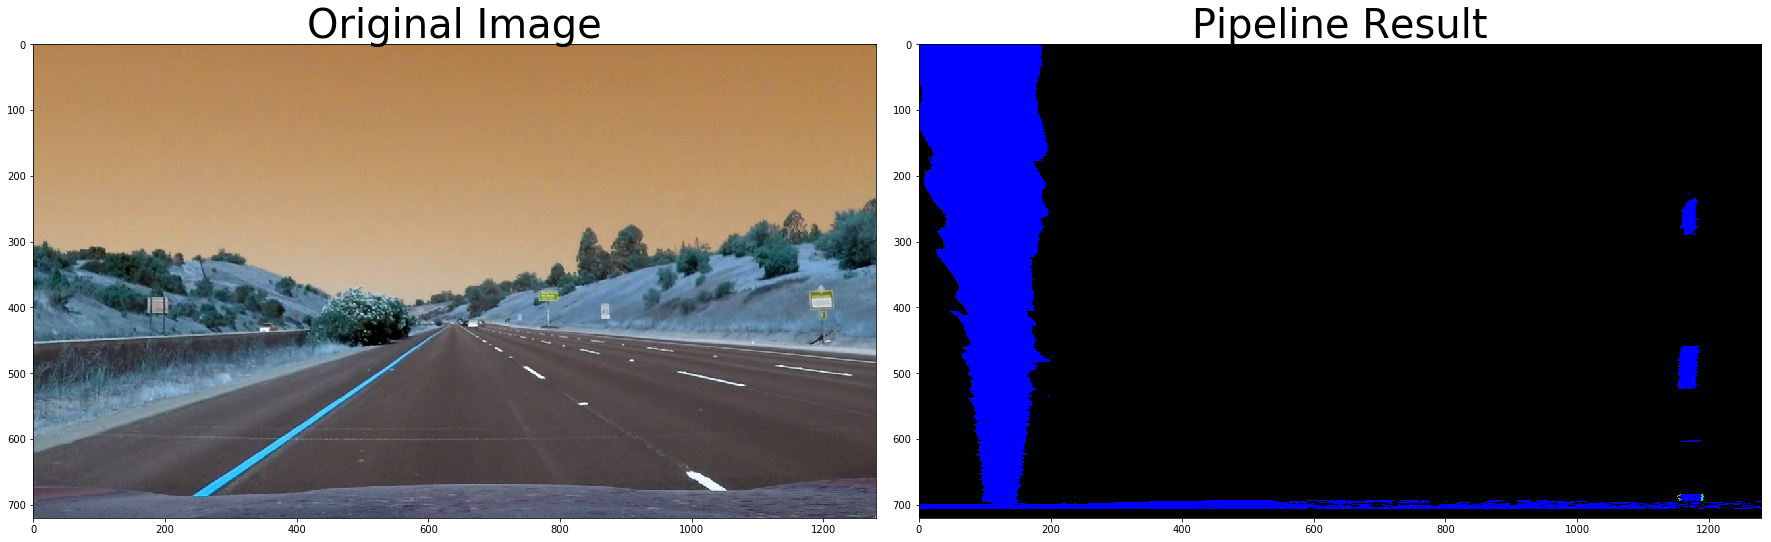

In [72]:
binary_img = pipeline(top_down, s_thresh=(30, 255), sx_thresh=(150, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

# print(result)
ax2.imshow(binary_img)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)